In [1]:
import os
from io import open
from conllu import parse
import networkx as nx
from Measures import Compute_measures
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DL = []
PMI = []

# Reading PMI values from CSV into a dictionary
pmi_dict = {}
df = pd.read_csv('Real_languages_MI_data.csv', delimiter='\t', names=['lang', 'h', 'd', 'pmi'])
pmi_dict = dict(zip(zip(df['h'], df['d']), df['pmi']))

directory = "./SUD"  # Directory containing the UD scheme tree files in CONLLU format
ud_files = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('train.conllu'):
            fullpath = os.path.join(root, file)
            ud_files.append(fullpath)  # Creates a list of paths of all files (file of each language) from the directory

for i in ud_files:  # Reads file of each language one by one

    data_file = open(str(i), 'r', encoding='utf-8').read()
    sentences = parse(data_file)  # parses the CONLLU format

    for sentence in sentences[0:]:
        tree = nx.DiGraph()  # An empty directed graph (i.e., edges are uni-directional)
        ROOT = 0
        tree.add_node(ROOT)
        for nodeinfo in sentence[0:]:  # retrieves information of each node from dependency tree in UD format
            entry = list(nodeinfo.items())
            if entry[7][1] != 'punct':
                tree.add_node(entry[0][1], form=entry[1][1], lemma=entry[2][1], upostag=entry[3][1],
                              xpostag=entry[4][1], feats=entry[5][1], head=entry[6][1], deprel=entry[7][1],
                              deps=entry[8][1], misc=entry[9][1])  # adds node to the directed graph
        
        nodes=tree.nodes
        get = Compute_measures(tree)

        for nodex in nodes:
            if (nodex != 0) and tree.has_node(nodes[nodex]['head']):                     # to handle disjoint trees
                tree.add_edge(nodes[nodex]['head'], nodex, drel=nodes[nodex]['deprel'])  # adds edges as relation between nodes

        for edgey in tree.edges:
            if edgey[0] != 0:
                dep_distance = get.dependency_distance(edgey)
                DL.append(dep_distance)
                PMI.append(pmi_dict.get((nodes[edgey[0]]['upostag'], nodes[edgey[1]]['upostag'])))

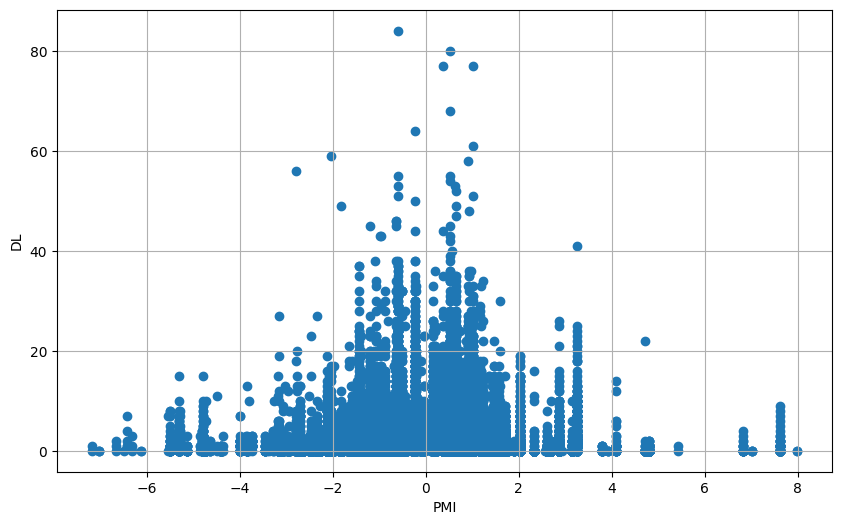

In [2]:
plt.figure(1,figsize=(10, 6))
plt.scatter(PMI,DL)
plt.xlabel('PMI')
plt.ylabel('DL')
plt.grid()
plt.show()

In [3]:
import statistics
from collections import defaultdict

DL_PMI = defaultdict(list)

for dl, pmi in zip(DL, PMI):
    DL_PMI[dl].append(pmi)

for dl, pmis in DL_PMI.items():
    valid_pmis = [pmi for pmi in pmis if pmi is not None]
    DL_PMI[dl] = statistics.mean(valid_pmis) if valid_pmis else None

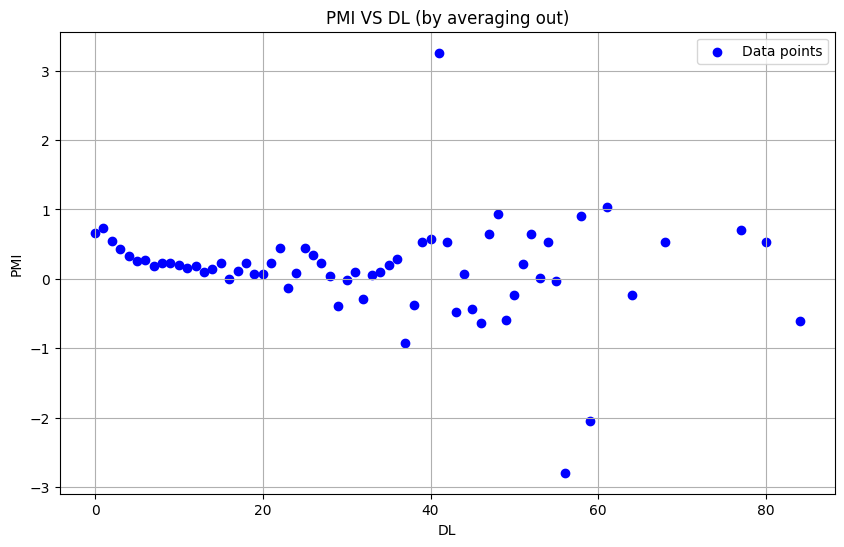

In [4]:
PMI_avg=list(DL_PMI.values())
DL_avg=list(DL_PMI.keys())

plt.figure(2,figsize=(10, 6))
plt.scatter(DL_avg, PMI_avg, color='blue', label='Data points')
plt.xlabel('DL')
plt.ylabel('PMI')
plt.title('PMI VS DL (by averaging out)')
plt.legend()
plt.grid()
plt.show()

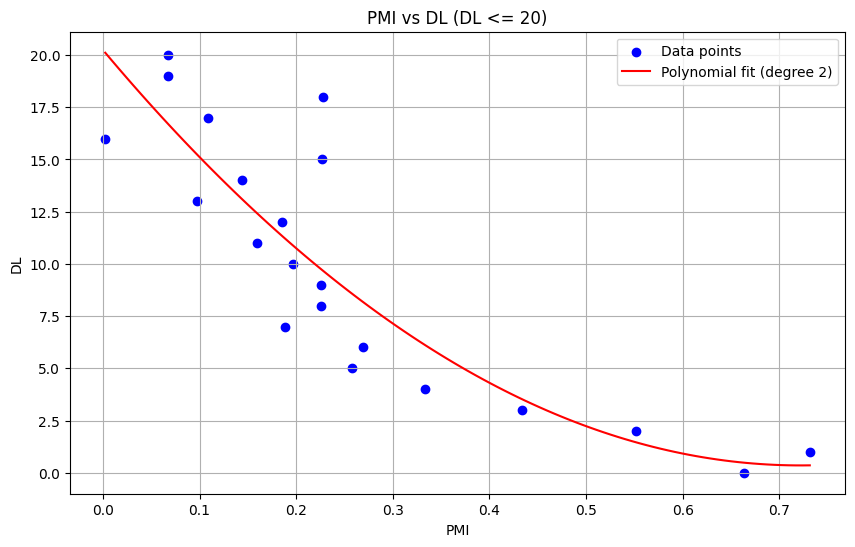

In [5]:
DL_20 = [dl for dl in DL_avg if dl <= 20]
PMI_20 = [PMI_avg[i] for i, dl in enumerate(DL_avg) if dl <= 20]

degree = 2
coefficients = np.polyfit(PMI_20, DL_20, degree)

PMI_fit=np.linspace(min(PMI_20),max(PMI_20),100)
DL_fit = np.polyval(coefficients, PMI_fit)

plt.figure(3,figsize=(10, 6))
plt.scatter(PMI_20, DL_20, color='blue', label='Data points')
plt.plot(PMI_fit, DL_fit, color='red', label=f'Polynomial fit (degree {degree})')
plt.xlabel('PMI')
plt.ylabel('DL')
plt.title('PMI vs DL (DL <= 20)')
plt.grid()
plt.legend()
plt.show()

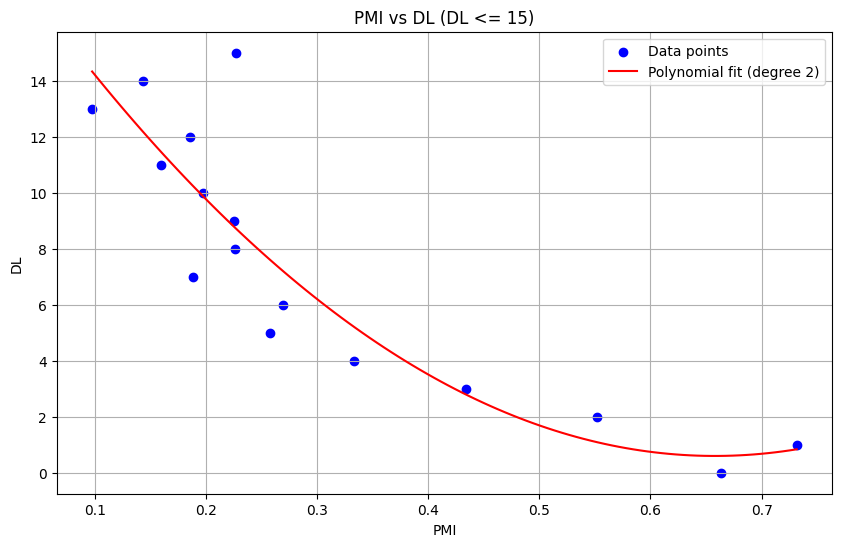

In [6]:
DL_15 = [dl for dl in DL_avg if dl <= 15]
PMI_15 = [PMI_avg[i] for i, dl in enumerate(DL_avg) if dl <= 15]

degree = 2
coefficients = np.polyfit(PMI_15, DL_15, degree)

PMI_fit=np.linspace(min(PMI_15),max(PMI_15),100)
DL_fit = np.polyval(coefficients, PMI_fit)

plt.figure(4,figsize=(10, 6))
plt.scatter(PMI_15, DL_15, color='blue', label='Data points')
plt.plot(PMI_fit, DL_fit, color='red', label=f'Polynomial fit (degree {degree})')
plt.xlabel('PMI')
plt.ylabel('DL')
plt.title('PMI vs DL (DL <= 15)')
plt.grid()
plt.legend()
plt.show()

In [9]:
DL=np.polyval(coefficients,0.4)
DL

3.506893739083303